In [13]:
%matplotlib inline

In [14]:
from IPython.display import display

import pandas as pd
import pint  # Unit conversion from inches to mm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D as Line
from matplotlib.patches import Polygon
from svg_model.svgload import svg_parser
from svg_model.data_frame import (get_svg_frame, close_paths, get_nearest_neighbours,
                                  get_path_areas, get_bounding_boxes, get_path_infos,
                                  get_bounding_box)



def scale_paths(df, axis, factor):
    df_scaled = df.copy()
    df_scaled[axis] = (df_scaled[axis + '_center'] +
                       df_scaled[axis + '_center_offset'] * factor)
    return df_scaled


def extend_paths(df, axis, distance):
    df_scaled = df.copy()
    offsets = df_scaled[axis + '_center_offset'].copy()
    offsets[offsets < 0] -= distance
    offsets[offsets >= 0] += distance
    df_scaled[axis] = df_scaled[axis + '_center'] + offsets
    return df_scaled


# Convert Inkscape pixels-per-inch (PPI) to pixels-per-mm (PPmm).
ureg = pint.UnitRegistry()

INKSCAPE_PPI = 90
INKSCAPE_PPmm = INKSCAPE_PPI / ureg.inch.to('mm')

-----------------------------------------------

## Work in progress - scale each path in an attempt to find "adjacent" paths

In [15]:
!pip install networkx

In [16]:
import networkx as nx


def get_path_colors(path_colors, df_connected):
    G = nx.Graph()
    G.add_edges_from(df_connected[['source','destination']].values)
    color_map = pd.Series(nx.coloring.greedy_color(G, interchange=True))
    map_colors = path_colors[:color_map.max() + 1]
    return pd.Series(map_colors[color_map], index=color_map.index)

In [17]:
def plot_paths(df_paths, path_colors=None, axis=None):
    if axis is None:
        # Create blank axis to draw on.
        fig, axis = plt.subplots(figsize=(10, 10))
        axis.set_aspect(True)

    if path_colors is None:
        # Get reference to cycling color generator.
        colors = axis._get_lines.color_cycle

        # Assign a color to each path identifier.
        path_ids = df_paths.path_id.unique()
        path_colors = pd.Series([colors.next()
                                 for i in xrange(path_ids.shape[0])],
                                index=path_ids)

    # Draw electrode paths
    for path_id, path_i in close_paths(df_paths).groupby('path_id'):
        color = path_colors[path_id]
        linewidth = 2
        edge = Polygon(path_i[['x', 'y']].values, edgecolor=color, closed=True,
                       linewidth=linewidth, facecolor='none')
        face = Polygon(path_i[['x', 'y']].values, edgecolor='none', closed=True,
                       facecolor=color, alpha=.45)
#         axis.add_patch(edge)
        axis.add_patch(face)   

        # Set limits of axis view to device boundaries.
    axis.set_xlim(df_paths.x.min(), df_paths.x.max())
    axis.set_ylim(df_paths.y.min(), df_paths.y.max())

    # Draw center of each electrode paths.
    path_centers = df_paths[['x_center', 'y_center']].drop_duplicates()
    axis.scatter(path_centers.x_center, path_centers.y_center)

    axis.set_xlabel('mm')
    axis.set_ylabel('mm')
    return axis

In [18]:
def get_paths_frame_with_centers(df_paths):
    df_paths = df_paths.copy()
    # Get coordinates of center of each path.
    df_paths_info = get_path_infos(df_paths)
    path_centers = df_paths_info[['x', 'y']] + .5 * df_paths_info[['width', 'height']].values
    df_paths['x_center'] = path_centers.x[df_paths.path_id].values
    df_paths['y_center'] = path_centers.y[df_paths.path_id].values

    # Calculate coordinate of each path vertex relative to center point of path.
    center_offset = df_paths[['x', 'y']] - df_paths[['x_center', 'y_center']].values
    return df_paths.join(center_offset, rsuffix='_center_offset')

In [19]:
def extract_adjacent_paths(df_paths, extend=.5):
    # Find corners of each solid path outline    
    df_scaled_x = extend_paths(df_paths, 'x', extend)  # Extend x coords by abs units
    df_scaled_y = extend_paths(df_paths, 'y', extend)  # Extend y coords by abs units

    df_corners = df_paths.groupby('path_id').agg({'x': ['min', 'max'], 'y': ['min', 'max'], })
    
    # Find adjacent electrodes
    row_list = [] 

    for pathNumber in df_paths['path_id'].drop_duplicates():
        df_stretched = df_scaled_x[df_scaled_x.path_id.isin([pathNumber])]
        xmin_x, xmax_x, ymin_x, ymax_x = (df_stretched.x.min(), df_stretched.x.max(),
                                          df_stretched.y.min(), df_stretched.y.max())
        df_stretched = df_scaled_y[df_scaled_y.path_id.isin([pathNumber])]
        xmin_y, xmax_y, ymin_y, ymax_y = (df_stretched.x.min(), df_stretched.x.max(),
                                          df_stretched.y.min(), df_stretched.y.max())

        #Some conditions unnecessary if it is assumed that electrodes don't overlap
        adjacent = df_corners[
                    ((df_corners.x['min'] < xmax_x) & (df_corners.x['max'] >= xmax_x)
                    |(df_corners.x['min'] < xmin_x) & (df_corners.x['max'] >= xmin_x)) # checks in x stretched direction
                   & (df_corners.y['min'] < ymax_x) & (df_corners.y['max'] > ymin_x)# check if y is within bounds

            #mabye do ymax_x - df_corners.y['min'] > threshold & df_corners.y['max'] - ymin_x > threshold

                    |((df_corners.y['min'] < ymax_y) & (df_corners.y['max'] >= ymax_y)
                     |(df_corners.y['min'] < ymin_y) & (df_corners.y['max'] >= ymin_y)) # checks in y stretched direction
                   & ((df_corners.x['min'] < xmax_y) & (df_corners.x['max'] > xmin_y)) # check if x in within bounds

                  ].index.values

        for path in adjacent:
            temp_dict = {}
            reverse_dict = {}

            temp_dict ['source'] = pathNumber
            reverse_dict['source'] = path
            temp_dict ['destination'] = path
            reverse_dict['destination'] = pathNumber

            if(reverse_dict not in row_list):
                row_list.append(temp_dict)

    df_connected = (pd.DataFrame(row_list)[['source', 'destination']]
                    .sort(axis=1, ascending=False).sort(['source', 'destination']))
    return df_connected

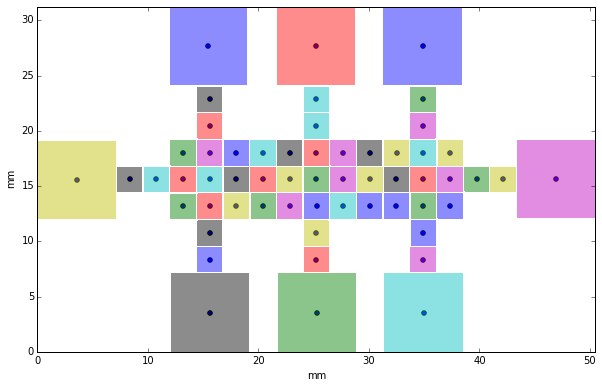

In [20]:
from IPython.display import display


svg_filepath = 'test_device_1.svg'

# Read device layout from SVG file.
df_device = get_svg_frame(svg_filepath)

# Offset device, such that all coordinates are >= 0.
df_device[['x', 'y']] -= df_device[['x', 'y']].min()

# Scale path coordinates based on Inkscape default of 90 pixels-per-inch.
df_device[['x', 'y']] /= INKSCAPE_PPmm.magnitude

df_paths = get_paths_frame_with_centers(df_device)
plot_paths(df_paths)
pass

## Drawing the Connections

In [21]:
# Extract [adjacency list][1] from paths data frame.
#
# [1]: https://en.wikipedia.org/wiki/Adjacency_list
df_connected = extract_adjacent_paths(df_paths)
df_connected['cost'] = 1

In [22]:
# Draws the connections
def draw_connections(df_paths, df_connected):    
    
    # Create blank axis to draw on.
    fig, axis = plt.subplots(figsize=(18, 10))
    axis.set_aspect(True)

    # Get reference to cycling color generator.
    colors = axis._get_lines.color_cycle

    # Collect enough colors from matplotlib color cycle to color electrodes.
    path_ids = df_paths.path_id.unique()
    colors_array = np.array([colors.next() for i in xrange(10)])[[0, 1, 3]]

    # Use `networkx` graph coloring algorithm to color electrodes.
    # (Avoids using same color for adjacent electrodes).
    path_colors = get_path_colors(colors_array, df_connected)
    plot_paths(df_paths, path_colors, axis=axis)
    path_centers = df_paths[['x_center', 'y_center']].drop_duplicates()

    for index, row in df_connected.iterrows():
        path_current = df_paths[df_paths.path_id == row['source']]
        path_adjacent = df_paths[df_paths.path_id == row['destination']]

        path_current = path_current.append(path_adjacent)
        poly = Polygon(path_current[['x_center','y_center']].values,
                       edgecolor=colors_array[0], facecolor='none', alpha=.4,
                       linewidth=5)
        axis.add_patch(poly)
    
    return axis, path_centers


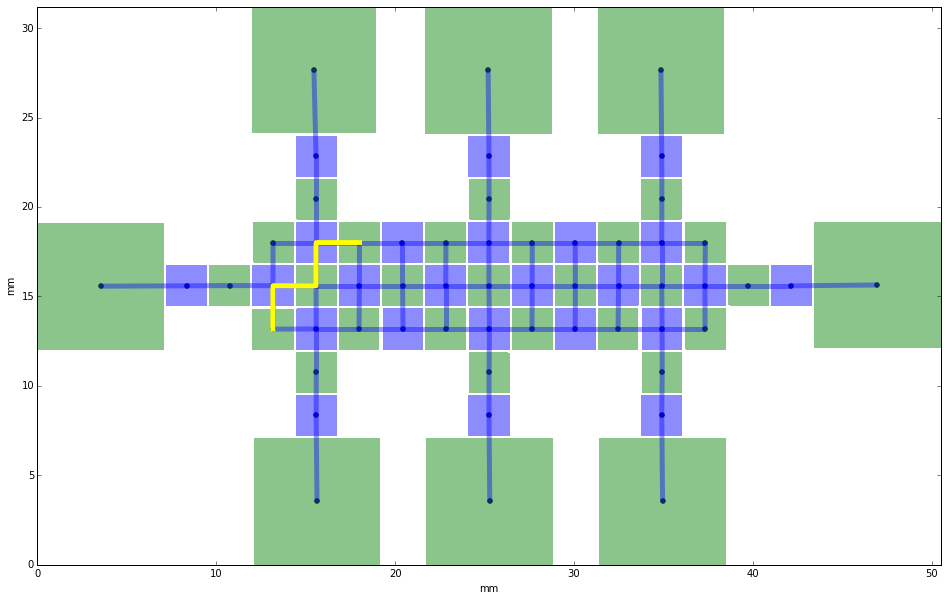

In [24]:
# Highlights the connections
def highlight_connections(axis, centers, graph, connection_ids):
    xs = [centers.ix[conn].x_center for conn in connection_ids]
    ys = [centers.ix[conn].y_center for conn in connection_ids]
    line = Line(xs, ys, color='yellow', linewidth=5)
    axis.add_line(line)


# Main
axis, centers = draw_connections(df_paths, df_connected)
highlight_connections(axis, centers, df_connected, [5,9,13,17,29])